# Junk Food Binary Classification with CLIP using ViT

This notebook implements a **CLIP** model for image classification from a **COCO JSON dataset**.

## Before you start

Make sure you have access to GPU. In case of any problems, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, click `Save` and try again.

In [1]:
!nvidia-smi

Mon Jan 12 18:12:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

HOME: /content
/content/datasets


## Install packages using pip


In [3]:
!pip install roboflow==1.2.11 open-clip-torch==3.2.0 pillow==11.3.0 torch==2.9.0 torchvision==0.24.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Download dataset from Roboflow

Don't forget to change the `API_KEY` with your dataset key.

The dataset from Roboflow comes in COCO format

In [4]:
from roboflow import Roboflow
from google.colab import userdata

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace(userdata.get('ROBOFLOW_WORKSPACE_ID')).project(userdata.get('ROBOFLOW_PROJECT_ID'))
version = project.version(userdata.get('ROBOFLOW_DATASET_VERSION'))
dataset = version.download("coco")

DATASET_PATH = "datasets/Junk-Food-Detection-10/"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Junk-Food-Detection-10 in coco:: 100%|██████████| 5280/5280 [00:02<00:00, 2067.79it/s]


In [5]:
%cd {HOME}

/content


## Prepare OpenCLIP model

In [6]:
import torch
import open_clip
from PIL import Image
from collections import defaultdict
import json

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-16",
    pretrained="laion2b_s34b_b88k"
)
tokenizer = open_clip.get_tokenizer("ViT-B-16")
model = model.to(device)
model.eval()

def classify_images_with_clip(dataset_part, classes):

    with open(DATASET_PATH + dataset_part +  "/" + "_annotations.coco.json", "r") as f:
        coco_data = json.load(f)

    # Build mappings
    category_id_to_name = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
    image_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

    # Group annotations by image_id
    image_annotations = defaultdict(list)
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        category_name = category_id_to_name[ann["category_id"]]
        image_annotations[image_id].append(category_name)

    # Get ground truth labels per image (unique categories)
    ground_truth = {}
    for image_id, categories in image_annotations.items():
        filename = image_id_to_filename[image_id]
        # Remove duplicates and normalize names
        unique_categories = list(set(categories))
        ground_truth[filename] = unique_categories

    # Prompt ensembling
    templates = [
        "a photo of {}",
        "a picture of {}",
        "an image containing {}",
        "a close-up photo of {}",
        "an ad containing {}"
    ]

    # Encode text, just once
    with torch.no_grad():
        text_features = []

        for cls in classes:
            prompts = [t.format(cls) for t in templates]
            tokens = tokenizer(prompts).to(device)

            embeddings = model.encode_text(tokens)
            embeddings /= embeddings.norm(dim=-1, keepdim=True)

            class_embedding = embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()

            text_features.append(class_embedding)

        text_features = torch.stack(text_features)

    # Binary classification parameters
    classification_threshold = 0.5  # Threshold for deciding between classes

    results = {}
    image_paths = [img["file_name"] for img in coco_data["images"]]

    for image_path in image_paths:
        try:
            image = Image.open(DATASET_PATH + dataset_part + "/" + image_path).convert("RGB")
            image_tensor = preprocess(image).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image_tensor)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                similarities = (image_features @ text_features.T).squeeze(0)

            # Binary classification: pick the class with highest similarity
            predicted_idx = similarities.argmax().item()
            predicted_class = classes[predicted_idx]
            predicted_score = similarities[predicted_idx].item()

            # Store single predicted class
            results[image_path] = predicted_class

        except FileNotFoundError:
            raise FileNotFoundError(f"Image file not found: {image_path}. Cannot continue processing.")

    return results, ground_truth, image_paths


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

## Metrics

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_predictions(image_paths, ground_truth, results, class_true, class_false):
  # ground_truth only have those images that have an annotation. So the images that don't, don't belong to ground_truth.
  # Therefore, let's ask if if the image_path belongs to ground_truth, if it does, then is the positive class (junk food). If not, it's negative class (non junk food)
  y_true = [1 if image_path in ground_truth else 0 for image_path in image_paths]
  y_pred = [1 if results[image_path] == class_true else 0 for image_path in image_paths]

  # No need for pos_label because we are already converting everything above with 0 and 1.
  return {
      'accuracy': accuracy_score(y_true, y_pred) * 100,
      'precision': precision_score(y_true, y_pred, zero_division=0),
      'recall': recall_score(y_true, y_pred, zero_division=0),
      'f1_score': f1_score(y_true, y_pred, zero_division=0),
      'confusion_matrix': confusion_matrix(y_true, y_pred)
  }

## Let's try some combinations in the valid set

We are using Prompt Optimization to get the most performant classes.

In [8]:
class_variants = [
  ["junk food", "something else"],
  ["junk food advertisements", "not junk food advertisements"],
  ["unhealthy food", "healthy food"],
  ["processed food", "whole food"],
  ["high-calorie food", "nutritious food"],
  ["unhealthy food advertisement", "healthy food advertisement"],
  ["fast food advertisement", "non-fast food advertisement"],
  ["junk food advertisement", "non-food advertisement"],
  ["junk food marketing", "non-food marketing"],
  ["unhealthy food promotion", "healthy food promotion"],
  ["food advertisement for unhealthy products", "other advertisements"],
  ["image of junk food being advertised", "image not advertising junk food"],
  ["advertisement showing unhealthy food", "advertisement not showing food"],
  ["promotional image of fast food", "non-promotional image"],
  ["mostly unhealthy food advertisement", "other advertisement"],
  ["unhealthy snack or fast food ad", "non-unhealthy food ad"],
  ["advertisement dominated by junk food", "advertisement without junk food"],
  ["sugary or fatty food", "nutritious food"],
  ["high-sugar high-fat food", "low-sugar low-fat food"],
  ["ultra-processed food", "minimally processed food"],
  ["fried food", "non-fried food"],
  ["candy or fast food", "fruits or vegetables"],
  ["soda or dessert", "water or produce"],
  ["commercial for unhealthy food", "commercial for healthy food"],
  ["marketing for junk food", "marketing for whole foods"],
  [
    "advertisement promoting unhealthy eating",
    "advertisement promoting healthy eating"
  ],
  [
    "promotional content for fast food",
    "promotional content for nutritious food"
  ],
  ["brand advertisement for junk food", "brand advertisement for healthy food"],
  ["fast food or candy", "fresh food"],
  ["chips or soda", "natural food"],
  ["burgers or pizza", "salad or grain"],
  ["dessert or fried food", "vegetable or fruit"],
  ["packaged snacks", "whole ingredients"],
  ["low-nutrition food", "high-nutrition food"],
  ["empty calorie food", "nutrient-dense food"],
  [
    "food high in added sugar or saturated fat",
    "food low in added sugar or saturated fat"
  ],
  ["nutritionally poor food", "nutritionally rich food"],
  ["food that contributes to poor health", "food that supports good health"],
  ["obesogenic food", "health-promoting food"],
  [
    "image featuring unhealthy food products",
    "image not featuring unhealthy food products"
  ],
  ["photo of junk food being marketed", "photo not of junk food"],
  ["picture showing fast food promotion", "picture not showing fast food"],
  ["visual of unhealthy food advertisement", "visual of other content"],
  ["ad for junk food", "ad for something else"],
  ["junk food ad", "not a junk food ad"],
  ["unhealthy food ad", "other ad"],
  ["fast food ad", "other ad"],
  [
    "advertisement image that primarily features or promotes unhealthy food products",
    "advertisement image that does not primarily feature unhealthy food"
  ],
  [
    "marketing material showing junk food or fast food",
    "marketing material not showing junk food or fast food"
  ],
  [
    "promotional imagery for high-calorie low-nutrient food",
    "promotional imagery for other products"
  ],
  ["fast food or processed snacks", "whole foods or other content"],
  ["sugary beverages or candy", "non-sugary products"],
  ["deep-fried food products", "non-fried items"],
  ["calorie-dense processed food", "nutrient-rich food or other imagery"],
  ["junk food brand promotion", "other brand promotion"],
  ["unhealthy eating advertisement", "non-unhealthy eating content"],
  ["promotion of sugar-laden products", "promotion of other products"],
  [
    "marketing for high-sodium food",
    "marketing for low-sodium food or other items"
  ],
  ["ad campaign for junk food brands", "ad campaign for other brands"],
  ["processed snack food", "unprocessed food or non-food"],
  ["chocolate or candy bars", "natural foods or other products"],
  ["energy drinks or soda", "healthy beverages or other items"],
  ["packaged desserts", "fresh produce or other content"],
  ["frozen fast food products", "fresh ingredients or other imagery"],
  ["sweetened cereal", "unsweetened options or other products"],
  [
    "advertisement for sugar-sweetened beverages",
    "advertisement for other beverages or products"
  ],
  [
    "promotion featuring fried or fatty foods",
    "promotion without fried or fatty foods"
  ],
  ["image promoting processed meats", "image not promoting processed meats"],
  [
    "visual content advertising junk food",
    "visual content not advertising junk food"
  ],
  ["fast food chain marketing", "other marketing content"],
  ["unhealthy snack promotion", "healthy snack or other promotion"],
  [
    "advertisement with high-fat processed food",
    "advertisement without high-fat processed food"
  ],
  ["marketing of sugar-heavy products", "marketing of other products"],
  [
    "promotional image of unhealthy beverages",
    "promotional image of other items"
  ],
  ["junk food product showcase", "non-junk food showcase"],
  ["processed snack food", "unprocessed food"],
  ["artificially flavored food", "naturally flavored food"],
  ["deep-fried food", "baked or steamed food"],
  ["sweetened beverage", "unsweetened beverage"],
  ["food with artificial additives", "food without artificial additives"],
  ["calorie-dense food", "nutrient-dense food"],
  ["refined grain product", "whole grain product"],
  ["food with trans fats", "food without trans fats"],
  ["sodium-heavy food", "low-sodium food"],
  ["sugary cereal or snack", "whole grain or protein snack"],
  ["carbonated sugary drink", "plain water or tea"],
  ["frozen processed meal", "fresh home-cooked meal"],
  ["packaged baked goods", "fresh produce"],
  ["candy bar or chocolate", "nuts or seeds"],
  ["energy drink or soda", "natural juice or water"],
  ["junk food brand promotion", "non-junk food content"],
  ["fast food chain advertisement", "non-fast food content"],
  [
    "promotional material for processed snacks",
    "promotional material for other products"
  ],
  [
    "marketing campaign for unhealthy beverages",
    "marketing campaign for other products"
  ],
  [
    "advertisement featuring sugary products",
    "advertisement not featuring sugary products"
  ],
  ["commercial promoting fried food", "commercial not promoting fried food"],
  ["marketing for high-sodium snacks", "marketing for low-sodium foods"],
  [
    "promotional content for candy or sweets",
    "promotional content not for candy"
  ],
  [
    "advertisement for ultra-processed items",
    "advertisement for minimally processed items"
  ],
  [
    "brand marketing for fast food chains",
    "brand marketing for other products"
  ],
  ["sponsored content for junk food", "sponsored content not for junk food"],
  [
    "promotional image of packaged snacks",
    "promotional image of other products"
  ],
  [
    "advertisement showing processed desserts",
    "advertisement not showing processed desserts"
  ],
  [
    "marketing visual for sweetened beverages",
    "marketing visual for other beverages"
  ],
  [
    "commercial featuring fried snacks",
    "commercial not featuring fried snacks"
  ],
  ["unhealthy meal option", "healthy meal option"],
  ["processed convenience food", "fresh whole food"],
  ["restaurant fast food", "home-cooked food"],
  ["takeout junk food", "prepared nutritious food"],
  ["drive-through food", "sit-down restaurant food"],
  ["value meal with fried items", "balanced meal with vegetables"],
  ["combo meal with soda", "meal with water"],
  ["super-sized portion", "regular portion"],
  ["kids meal with toys", "nutritious kids meal"],
  ["limited-time unhealthy offer", "non-food limited-time offer"],
  ["greasy food", "non-greasy food"],
  ["artificial food coloring", "natural food"],
  ["heavily processed food item", "lightly processed food item"],
  ["food lacking nutritional value", "food with nutritional value"],
  ["indulgent unhealthy treat", "wholesome treat"],
  ["chemically preserved food", "naturally preserved food"],
  ["instant processed food", "freshly prepared food"],
  ["mass-produced junk food", "artisanal healthy food"],
  ["factory-made snack", "homemade snack"],
  ["shelf-stable processed food", "perishable fresh food"],
  ["advertisement for sugary snacks", "advertisement for non-sugary products"],
  [
    "advertisement for soft drinks or candy",
    "advertisement for non-food products"
  ],
  ["fast food brand promotion", "promotion for a different product"],
  [
    "junk food brand logo in an advertisement",
    "advertisement without junk food branding"
  ],
  [
    "advertisement featuring burgers fries or soda",
    "advertisement featuring non-food items"
  ],
  ["food ad showing oversized portions", "food ad showing balanced portions"],
  [
    "advertisement promoting snacks or sweets",
    "advertisement promoting non-food items"
  ],
  [
    "advertisement highlighting indulgent food",
    "advertisement highlighting healthy or non-food content"
  ],
  [
    "ad image with processed snack packaging",
    "ad image without processed food packaging"
  ],
  [
    "marketing image centered on fast food meals",
    "marketing image centered on other themes"
  ],
  [
    "advertisement encouraging junk food consumption",
    "advertisement not encouraging junk food consumption"
  ],
  [
    "visual advertisement for high-calorie snacks",
    "visual advertisement for other products"
  ],
  ["photo of a fast food meal in an ad", "photo not showing a fast food meal"],
  [
    "image of sugary drinks being promoted",
    "image not promoting sugary drinks"
  ],
  [
    "advertisement with candy soda or chips",
    "advertisement without candy soda or chips"
  ],
  [
    "advertisement for convenience food",
    "advertisement for non-convenience items"
  ],
  [
    "advertisement showing heavily processed food",
    "advertisement showing minimally processed or non-food items"
  ],
  [
    "promotional image of takeout or drive-through food",
    "promotional image not related to takeout food"
  ],
  [
    "advertisement focused on indulgent eating",
    "advertisement focused on other topics"
  ],
  [
    "food marketing associated with unhealthy diets",
    "marketing not associated with unhealthy diets"
  ]
]

results_list = []
for classes in class_variants:
    results, ground_truth, image_paths = classify_images_with_clip(
        dataset_part="valid",
        classes=classes
    )
    metrics = evaluate_predictions(
        image_paths=image_paths,
        ground_truth=ground_truth,
        results=results,
        class_true=classes[0],
        class_false=classes[1],
    )
    results_list.append({
        'classes': classes,
        **metrics,
    })

results_list.sort(key=lambda x: x['f1_score'], reverse=True)

print("\n" + "="*80)
print("RESULTS SORTED BY F1 SCORE (BEST FIRST)")
print("="*80)

for i, result in enumerate(results_list, 1):
    print(f"\n{i}. F1 Score: {result['f1_score']:.2f}%")
    print(f"   Accuracy: {result['accuracy']:.2f}%")
    print(f"   Precision: {result['precision']:.2f}%")
    print(f"   Recall: {result['recall']:.2f}%")
    print(f"   Confusion Matrix: {result['confusion_matrix']}")
    print("-"*80)


RESULTS SORTED BY F1 SCORE (BEST FIRST)

1. F1 Score: 0.82%
   Accuracy: 77.27%
   Precision: 0.82%
   Recall: 0.82%
   Confusion Matrix: [[112  51]
 [ 49 228]]
--------------------------------------------------------------------------------

2. F1 Score: 0.82%
   Accuracy: 77.95%
   Precision: 0.84%
   Recall: 0.80%
   Confusion Matrix: [[122  41]
 [ 56 221]]
--------------------------------------------------------------------------------

3. F1 Score: 0.82%
   Accuracy: 76.59%
   Precision: 0.80%
   Recall: 0.84%
   Confusion Matrix: [[103  60]
 [ 43 234]]
--------------------------------------------------------------------------------

4. F1 Score: 0.82%
   Accuracy: 73.41%
   Precision: 0.72%
   Recall: 0.94%
   Confusion Matrix: [[ 64  99]
 [ 18 259]]
--------------------------------------------------------------------------------

5. F1 Score: 0.81%
   Accuracy: 72.05%
   Precision: 0.72%
   Recall: 0.92%
   Confusion Matrix: [[ 63 100]
 [ 23 254]]
------------------------------

## Run model on test set with the best 10 classes

Let's check the 10 classes and sort the result by F1 Score. Notice that the sort order from the validation set might be different, that's why we need to sort again.


TEST SET METRICS - Variant 1
Classes: ['ad for junk food', 'ad for something else']
Accuracy: 0.821
Precision: 0.829 (ad for junk food)
Recall: 0.885 (ad for junk food)
F1-Score: 0.856 (ad for junk food)
Confusion Matrix:


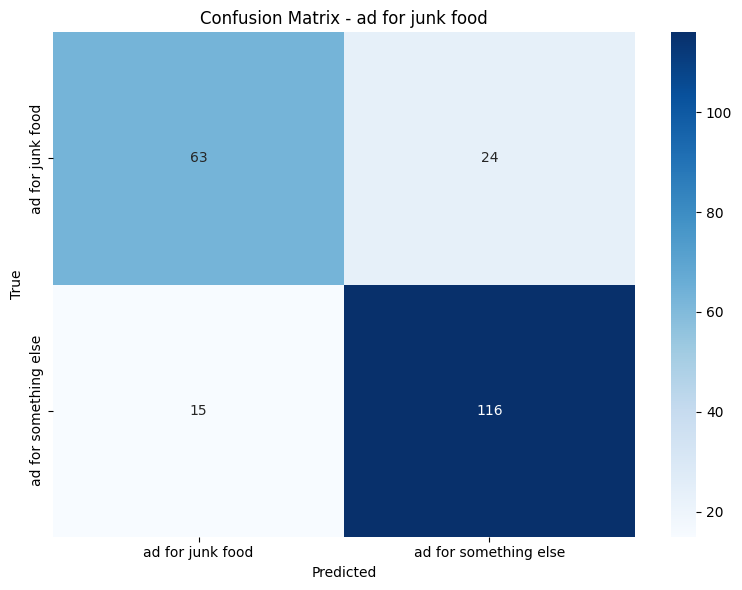


TEST SET METRICS - Variant 2
Classes: ['fast food chain marketing', 'other marketing content']
Accuracy: 0.775
Precision: 0.789 (fast food chain marketing)
Recall: 0.855 (fast food chain marketing)
F1-Score: 0.821 (fast food chain marketing)
Confusion Matrix:


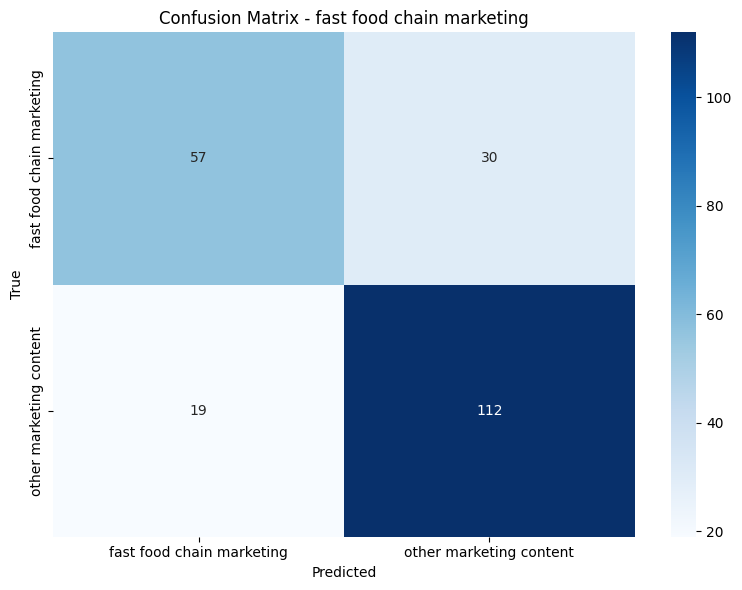


TEST SET METRICS - Variant 3
Classes: ['marketing image centered on fast food meals', 'marketing image centered on other themes']
Accuracy: 0.789
Precision: 0.840 (marketing image centered on fast food meals)
Recall: 0.802 (marketing image centered on fast food meals)
F1-Score: 0.820 (marketing image centered on fast food meals)
Confusion Matrix:


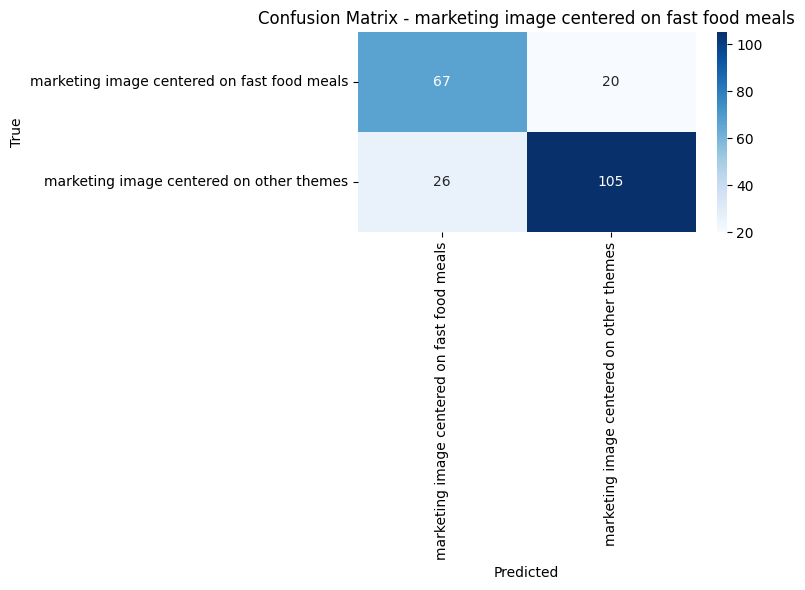


TEST SET METRICS - Variant 4
Classes: ['fast food brand promotion', 'promotion for a different product']
Accuracy: 0.761
Precision: 0.765 (fast food brand promotion)
Recall: 0.870 (fast food brand promotion)
F1-Score: 0.814 (fast food brand promotion)
Confusion Matrix:


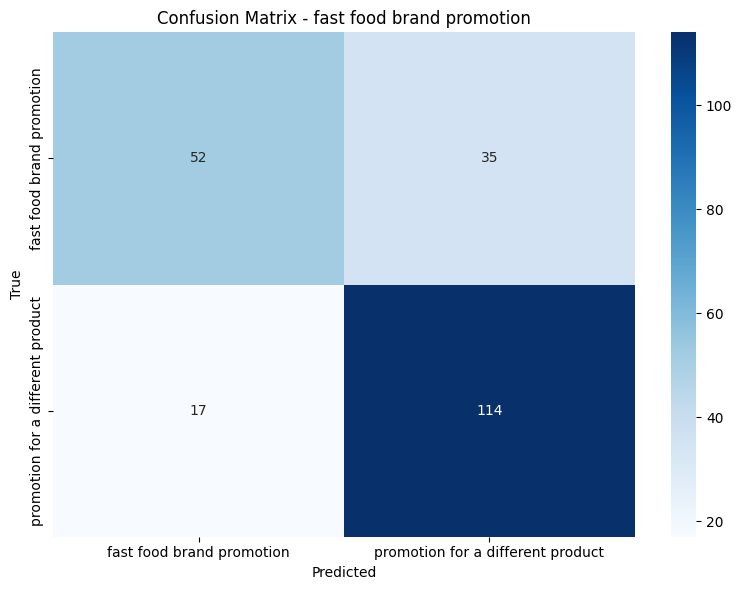


TEST SET METRICS - Variant 5
Classes: ['visual of unhealthy food advertisement', 'visual of other content']
Accuracy: 0.794
Precision: 0.891 (visual of unhealthy food advertisement)
Recall: 0.748 (visual of unhealthy food advertisement)
F1-Score: 0.813 (visual of unhealthy food advertisement)
Confusion Matrix:


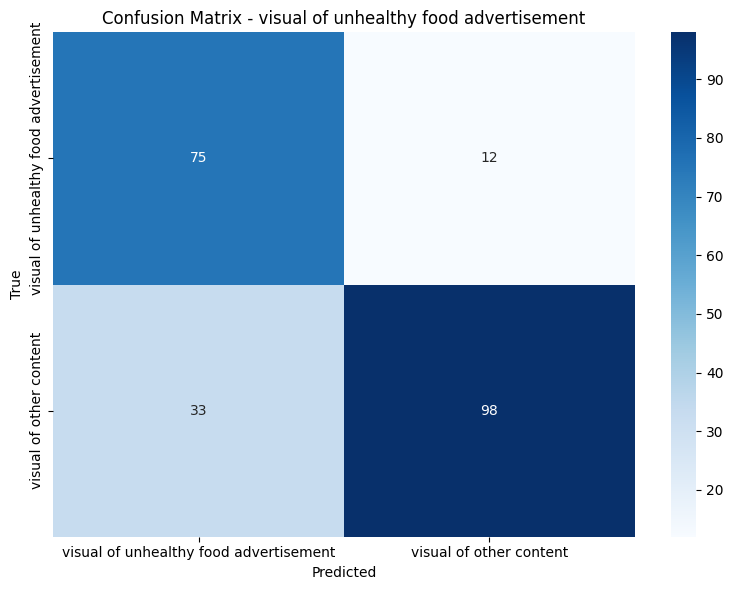


TEST SET METRICS - Variant 6
Classes: ['marketing for junk food', 'marketing for whole foods']
Accuracy: 0.697
Precision: 0.688 (marketing for junk food)
Recall: 0.908 (marketing for junk food)
F1-Score: 0.783 (marketing for junk food)
Confusion Matrix:


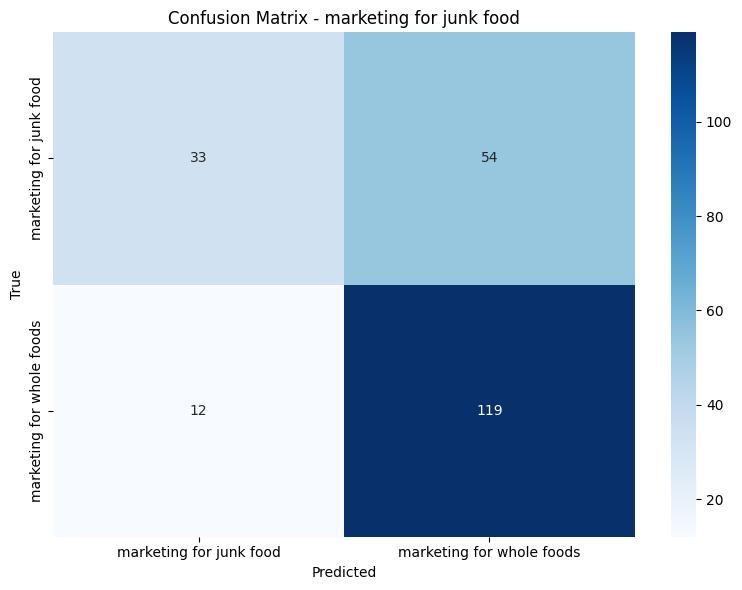


TEST SET METRICS - Variant 7
Classes: ['carbonated sugary drink', 'plain water or tea']
Accuracy: 0.720
Precision: 0.740 (carbonated sugary drink)
Recall: 0.824 (carbonated sugary drink)
F1-Score: 0.780 (carbonated sugary drink)
Confusion Matrix:


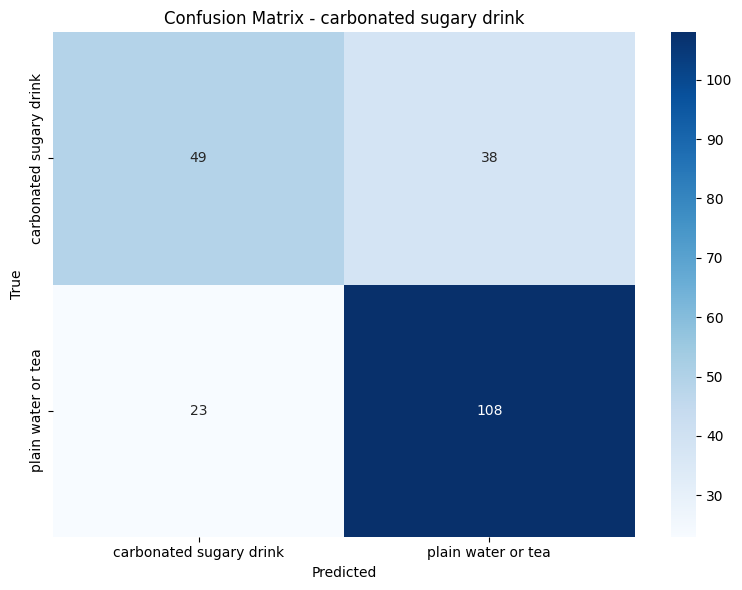


TEST SET METRICS - Variant 8
Classes: ['processed convenience food', 'fresh whole food']
Accuracy: 0.661
Precision: 0.645 (processed convenience food)
Recall: 0.969 (processed convenience food)
F1-Score: 0.774 (processed convenience food)
Confusion Matrix:


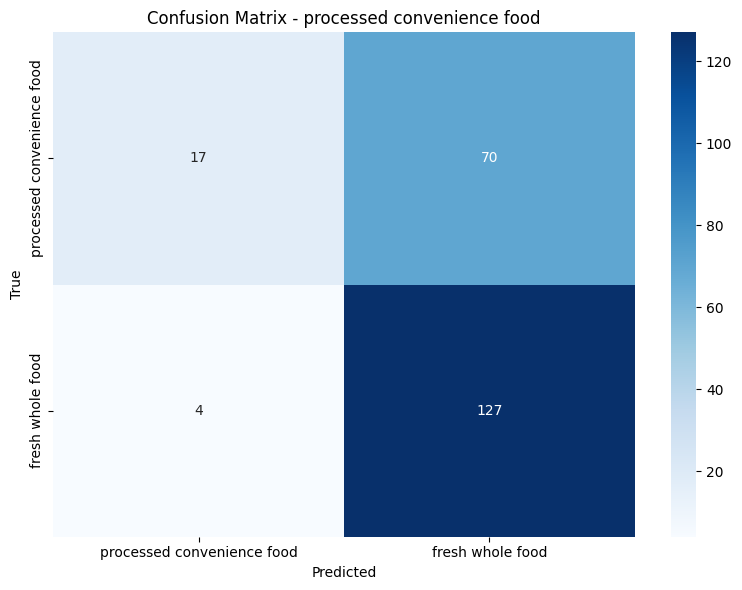


TEST SET METRICS - Variant 9
Classes: ['advertisement highlighting indulgent food', 'advertisement highlighting healthy or non-food content']
Accuracy: 0.693
Precision: 0.698 (advertisement highlighting indulgent food)
Recall: 0.863 (advertisement highlighting indulgent food)
F1-Score: 0.771 (advertisement highlighting indulgent food)
Confusion Matrix:


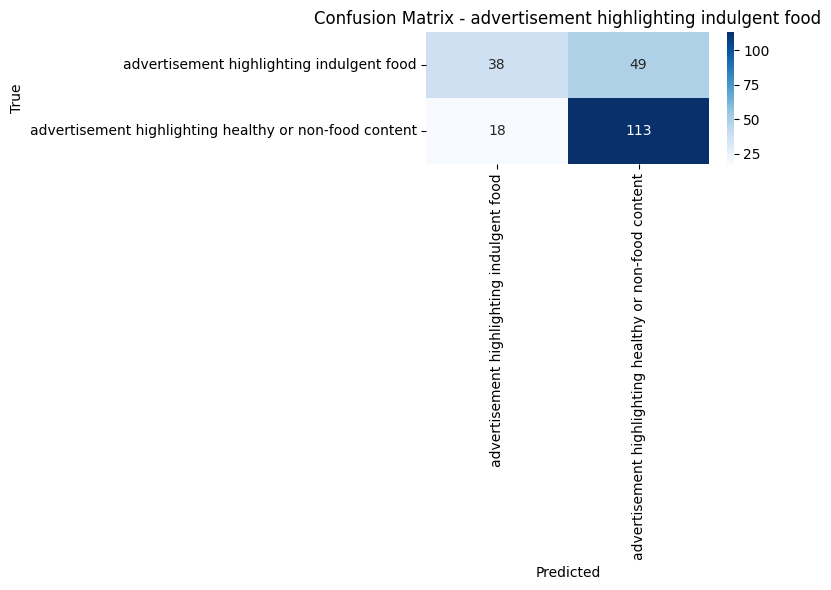


TEST SET METRICS - Variant 10
Classes: ['processed food', 'whole food']
Accuracy: 0.661
Precision: 0.656 (processed food)
Recall: 0.916 (processed food)
F1-Score: 0.764 (processed food)
Confusion Matrix:


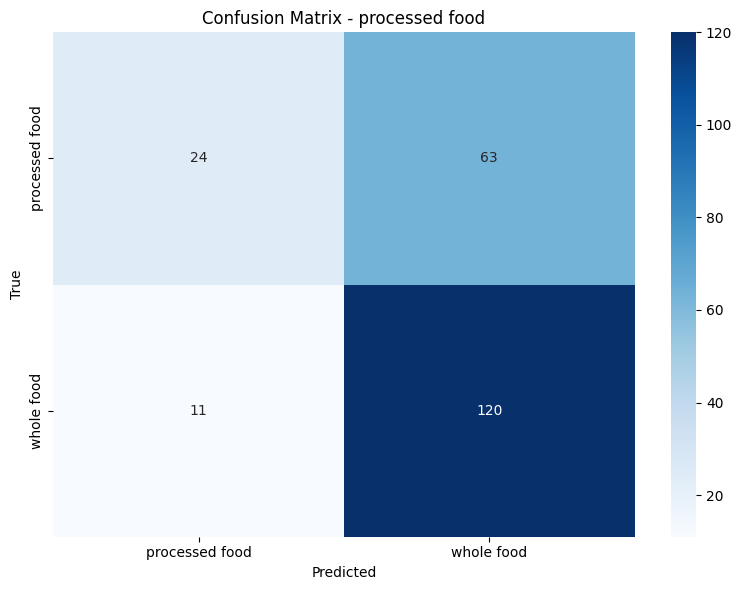

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Collect test results for the best 10 classes from validation
test_results_list = []

for i, result in enumerate(results_list[:10], 1):
    results, ground_truth, image_paths = classify_images_with_clip(
        dataset_part="test", classes=result["classes"]
    )
    metrics = evaluate_predictions(
        image_paths=image_paths,
        ground_truth=ground_truth,
        results=results,
        class_true=result["classes"][0],
        class_false=result["classes"][1],
    )
    test_results_list.append({
        "classes": result["classes"],
        "metrics": metrics
    })

test_results_list.sort(key=lambda x: x["metrics"]["f1_score"], reverse=True)

for i, result in enumerate(test_results_list, 1):
    metrics = result["metrics"]
    class_name = result['classes'][0]

    print("\n" + "="*50)
    print(f"TEST SET METRICS - Variant {i}")
    print(f"Classes: {result['classes']}")
    print("="*50)
    print(f"Accuracy: {metrics['accuracy'] / 100:.3f}")
    print(f"Precision: {metrics['precision']:.3f} ({class_name})")
    print(f"Recall: {metrics['recall']:.3f} ({class_name})")
    print(f"F1-Score: {metrics['f1_score']:.3f} ({class_name})")
    print("Confusion Matrix:")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        metrics['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[class_name, result['classes'][1]],
        yticklabels=[class_name, result['classes'][1]]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {class_name}')
    plt.tight_layout()
    plt.show()